In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import json, re, sys, os
import matplotlib.gridspec as gridspec

sys.path.append("..")
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 11})

colors = {'sts_cp': 'green', 'splatt': 'royalblue', 'cp_arls_lev': 'darkorange'}

In [3]:
def parse_splatt_trace(filepath):
    with open(filepath, 'r') as f:
        text = f.read()

        # Split the text into segments using the ***** delimiter
        segments = re.split(r'\*{64,}', text)
        segments = [segment for segment in segments if 'splatt v2.0.0' in segment]
        
        # Define the regular expression pattern to extract fit vs. time data
        #pattern = r'its = (\d+) \((\d+\.\d+s)\)  fit = ([\d.]+)'
        pattern = r'its\s*=\s*(\d+)\s*\(([\d.]+s)\)\s*fit\s*=\s*([\d.]+)'

        # Initialize a list to store time/fit/iteration pairs for each segment
        segment_fit_data = []

        # Process each segment separately
        for segment in segments:
             # Extract fit and time values for this segment
            segment_data = {'iterations': [], 'times': [], 'fits': []}
            factor_pattern = r'NFACTORS=(\d+)'

            # Use re.search to find the match
            factor_match = re.search(factor_pattern, segment)

            # Check if a match was found
            if factor_match:
                # Extract the NFACTORS value from the match
                segment_data["rank"] = int(factor_match.group(1))
            
            # Use regular expressions to extract fit vs. time data from each segment
            matches = re.findall(pattern, segment)

            for match in matches:
                iteration, time, fit = match
                segment_data['iterations'].append(int(iteration))
                segment_data['times'].append(float(time[:-1]))
                segment_data['fits'].append(float(fit))

            segment_data['times'] = np.cumsum(segment_data['times'])
            # Append the data for this segment to the list
            segment_fit_data.append(segment_data)
            
        return segment_fit_data
        
def generate_trace_ours(directory, fields):
    exps = []
    for filepath in os.listdir(directory):
        if filepath.endswith('.out'):
            with open(os.path.join(directory, filepath), 'r') as f:
                exps.append(json.load(f))
            
    filtered_exps = []
    for exp in exps:
        match = True
        for key in fields:
            if fields[key] != exp[key]:
                match = False
        
        if match:
            filtered_exps.append(exp)
            
    data = []
    
    for exp in filtered_exps:
        exp_data = {}
        exp_data['iterations'] = exp['stats']['rounds']
        exp_data['times'] = exp['stats']['als_times']
        exp_data['fits'] = exp['stats']['fits']
        
        data.append(exp_data)
        
    return data

def generate_interpolation(data):
    '''
    Data must be structured as a list of dictionaries, each with keys 'iterations', 'times', and 'fits'
    that each point to a list.
    '''
    max_time = np.max([np.max(trace['times']) for trace in data])
    x_axis = np.linspace(0, max_time, 10000)
        
    interpolations = []
    for trace in data:
        max_fits = [np.max(trace['fits'][:i]) for i in range(1,len(trace['fits']) + 1)]
        interp_y = np.interp(x_axis, xp=trace['times'], fp=max_fits)
        interpolations.append(interp_y)
            
    interpolations = np.array(interpolations)
    mean_interp = np.mean(interpolations, axis=0)
        
    return x_axis, mean_interp

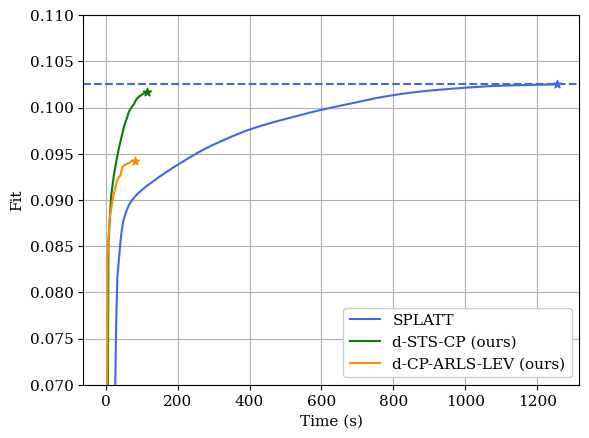

In [3]:
fig, ax = plt.subplots()

x_splatt, y_splatt = generate_interpolation(parse_splatt_trace('../data/fit_progress_vs_time/reddit_trace_splatt.txt'))
x_sts_cp, y_sts_cp = generate_interpolation(generate_trace_ours('../data/fit_progress_vs_time', 
                                                                {
                                                                    'input': 'reddit',
                                                                    'algorithm': 'sts_cp',
                                                                    'sample_count': 98304,
                                                                    'target_rank': 100
                                                                }))
x_cp_arls_lev, y_cp_arls_lev = generate_interpolation(generate_trace_ours('../data/fit_progress_vs_time', 
                                                                {
                                                                    'input': 'reddit',
                                                                    'algorithm': 'cp_arls_lev',
                                                                    'sample_count': 98304,
                                                                    'target_rank': 100
                                                                }))

ax.plot(x_splatt, y_splatt, label="SPLATT", c=colors['splatt'])
ax.plot(x_sts_cp, y_sts_cp, label="d-STS-CP (ours)",c=colors['sts_cp'])
ax.plot(x_cp_arls_lev, y_cp_arls_lev, label="d-CP-ARLS-LEV (ours)",c=colors['cp_arls_lev'])
ax.scatter(x_splatt[-1], y_splatt[-1], marker='*',c=colors['splatt'])
ax.scatter(x_sts_cp[-1], y_sts_cp[-1], marker='*',c=colors['sts_cp'])
ax.scatter(x_cp_arls_lev[-1], y_cp_arls_lev[-1], marker='*',c=colors['cp_arls_lev'])

ax.axhline(max(y_splatt), linestyle='--', c=colors['splatt'])

ax.grid(True)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Fit")
ax.set_ylim([0.07, 0.11])
ax.legend(loc='lower right', framealpha=1.0)
fig.savefig('figures/fit_vs_time_reddit.pdf')

In [10]:
# Information for the highlight slug

print(max(x_splatt))
print(max(y_splatt))
print(max(x_sts_cp))
print(max(y_sts_cp))
print(max(x_cp_arls_lev))
print(max(y_cp_arls_lev))
x_splatt[np.argwhere(y_splatt > max(y_cp_arls_lev))[0]]

print(max(y_sts_cp) / max(y_splatt))

1253.9329999999993
0.10250200000000001
114.17030657900001
0.10169376591106802
81.92607694399999
0.09422406209768017
0.9921149432310394


In [15]:
# Generate the accuracy table for our algorithm
tensor_print_map = {
    "uber": "Uber",
    "amazon": "Amazon",
    "reddit": "Reddit"
}
result_map = {}

table = ""
for tensor in ["uber", "amazon", "reddit"]:
    first = True
    for rank in [25, 50, 75]:
        for alg in ['cp_arls_lev', 'sts_cp']:
            traces = generate_trace_ours('../data/accuracy_benchmarks',
                                         {
                                             'input': 'reddit',
                                             'algorithm': alg,
                                             'sample_count': 65536,
                                             'target_rank': rank
                                         })
            if len(traces) < 5:
                print(f"{tensor} {rank} {alg} incomplete! Trace count is {len(traces)}")
            max_fits = [np.max(trace['fits']) for trace in traces]
            mean_fit = np.mean(max_fits)
            std_fit = np.std(max_fits)
            result_map[(tensor, rank, alg)] = (mean_fit, std_fit)
            
        if first:
            first = False
            table += "\\multirow{3}{*}{" + tensor_print_map[tensor] + "}   \n"
        
        if tensor != "reddit":
            table += f"& {rank}   & {result_map[tensor, rank, 'cp_arls_lev'][0]:.3f} & {result_map[tensor, rank, 'sts_cp'][0]:.3f} & 0 \\\\ \n"
        else:
             table += f"& {rank}   & {result_map[tensor, rank, 'cp_arls_lev'][0]:.4f} & {result_map[tensor, rank, 'sts_cp'][0]:.4f} & 0 \\\\ \n"
    table += "\\midrule\n"
    
table += "\\bottomrule\n"
    
print(table)

\multirow{3}{*}{Uber}   
& 25   & 0.058 & 0.059 & 0 \\ 
& 50   & 0.075 & 0.078 & 0 \\ 
& 75   & 0.085 & 0.091 & 0 \\ 
\midrule
\multirow{3}{*}{Amazon}   
& 25   & 0.058 & 0.059 & 0 \\ 
& 50   & 0.075 & 0.078 & 0 \\ 
& 75   & 0.085 & 0.091 & 0 \\ 
\midrule
\multirow{3}{*}{Reddit}   
& 25   & 0.0583 & 0.0592 & 0 \\ 
& 50   & 0.0746 & 0.0775 & 0 \\ 
& 75   & 0.0848 & 0.0910 & 0 \\ 
\midrule
\bottomrule



In [6]:
# data is a list of dictionaries, all of which must have the same keys. 
def make_stacked_barchart(ax, x_positions, width, data, keys, tick_labels=None, vertical=True, label=True, colors=None):
    num_bars = len(data)
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf'] # Default Matplotlib color cycle

    bar_edges = np.zeros(num_bars)
    for i in range(len(keys)):
        bar_data = np.array([data[j][keys[i]] for j in range(num_bars)]) 
        
        if label:
            label_to_use = keys[i]
        else:
            label_to_use = None
            
        if vertical:
            func = ax.bar
        else:
            func = ax.barh
        
        func(x_positions, bar_data, width, bottom=bar_edges, edgecolor='black', label=label_to_use, color=colors[i])
        bar_edges += bar_data

    if tick_labels is not None:
        if vertical:
            ax.set_xticks(x_positions)
            ax.set_xticklabels(tick_labels)
        else:
            ax.set_yticks(x_positions)
            ax.set_yticklabels(tick_labels)

    ax.grid(True)

/tmp/ipykernel_677149/893460639.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("figures/strong_scaling_25_cp_arls_lev.pdf", bbox_inches='tight')
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


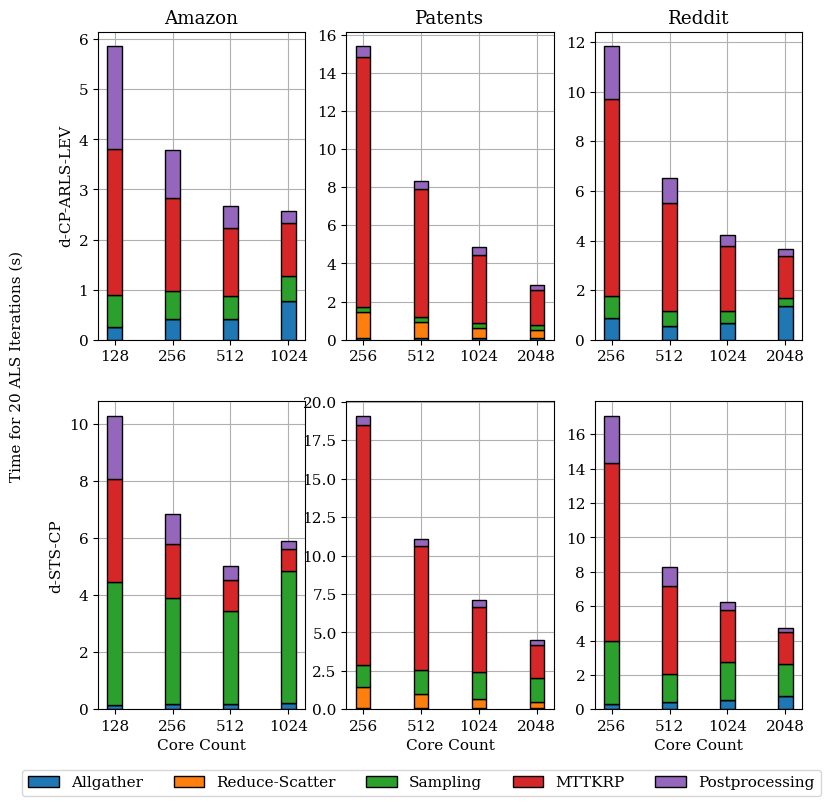

In [11]:
# Strong scaling experiments

def get_strong_scaling_measurements(directory, fields):
    exps = []
    for filepath in os.listdir(directory):
        if filepath.endswith('.out'):
            with open(os.path.join(directory, filepath), 'r') as f:
                exps.append(json.load(f))
            
    filtered_exps = []
    for exp in exps:
        match = True
        for key in fields:
            if fields[key] != exp[key]:
                match = False
        
        if match:
            filtered_exps.append(exp)
            
    results = {}
    
    stat_fields = ['leverage_sampling_time', 'row_gather_time', 'design_matrix_prep_time', 'spmm_time', 
              'dense_reduce_time', 'postprocessing_time', 'sampler_update_time']
    
    for field in stat_fields:
        if len(filtered_exps) > 0:
            results[field] = np.mean([exp['stats'][field]['mean'] for exp in filtered_exps])
        else:
            results[field] = 0.0
        
    if len(filtered_exps) > 0:
        results['als_time']=np.mean([exp['stats']['als_total_time'] for exp in filtered_exps])
    else:
        results[field] = 0.0
            
    return results

def stats_to_bar(stats):
    bar = { 'Allgather': stats['row_gather_time'],
            'Reduce-Scatter': stats['dense_reduce_time'],
            'Sampling': stats['leverage_sampling_time'],
            'MTTKRP': stats['design_matrix_prep_time'] + stats['spmm_time'],
            'Postprocessing': stats['sampler_update_time'] + stats['postprocessing_time']
          }
    return bar

num_tensors=3

fig = plt.figure(tight_layout=True)
fig.set_size_inches(8 * (1.1), 8 * (1.1))
spec = fig.add_gridspec(2, num_tensors, left=0.0, right=0.8)
axs = [[fig.add_subplot(spec[i, j]) for j in range(num_tensors)] for i in range(2)]

#for i in range(1, num_tensors):
#    axs[i].sharey(axs[0])
#    axs[i].label_outer()

for j in range(2):
    for i in range(num_tensors):
        axs[j][i].grid(True)
        
        if j == 1:
            axs[j][i].set_xlabel("Core Count")

            
axs[0][0].set_ylabel("d-CP-ARLS-LEV")
axs[1][0].set_ylabel("d-STS-CP")


tensors = ['amazon', 'patents', 'reddit']
algs = ['cp_arls_lev', 'sts_cp']
tensor_node_counts = {'amazon': [1, 2, 4, 8], 'patents': [2, 4, 8, 16], 'reddit': [2, 4, 8, 16]}

for idx1, tensor in enumerate(tensors):
    for idx2, alg in enumerate(algs):
        exps = []
        node_counts = tensor_node_counts[tensor]
        for node_count in node_counts:
            exps.append(get_strong_scaling_measurements('../data/strong_scaling', 
                                                        {
                                                        'input': tensor,
                                                        'algorithm': alg,
                                                        'sample_count': 65536,
                                                        'target_rank': 25,
                                                        'node_count': str(node_count)
                                                        }))
            
        x = np.log(node_counts) / np.log(2)
        bars = [stats_to_bar(exp) for exp in exps]
        make_stacked_barchart(axs[idx2][idx1], x, 0.25, bars, list(bars[0].keys()), [ct * 128 for ct in node_counts], vertical=True, label=(idx1+idx2==0))
        axs[idx2][idx1].set_axisbelow(True)
    axs[0][idx1].set_title(tensor.capitalize())

fig.text(-0.1, 0.5, 'Time for 20 ALS Iterations (s)', va='center', rotation='vertical')
fig.legend(bbox_to_anchor=(0.83,0.05),ncol=5)
fig.savefig("figures/strong_scaling_25_cp_arls_lev.pdf", bbox_inches='tight')
fig.show()

[1. 1. 1.]
[5.84890057 5.91324397 5.47372271]
[ 9.45525431 10.56377058 11.31457958]
[1. 1. 1.]
[0.81637693 1.28109525 1.59975724]
[1.23981747 1.91284521 2.77199844]
[1. 1. 1.]
[ 6.80064363  8.61333237 10.7037374 ]
[ 8.1804033  11.66676019 14.60935644]
[1. 1. 1.]
[2.35678819 2.81214061 2.45761543]
[3.93407806 5.0179871  5.78464272]
[1. 1. 1.]
[0.41638353 0.80973994 0.87920807]
[1.01316456 1.98819554 2.04317148]
[1. 1. 1.]
[2.78941417 3.44636315 5.09449692]
[3.58848911 4.80250265 6.94910748]


/tmp/ipykernel_1045254/1580094461.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('figures/speedup_over_splatt.pdf',  bbox_inches='tight')
/global/common/software/nersc/pe/conda-envs/23.9.0/python-3.11/nersc-python/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/global/common/software/nersc/pe/conda-envs/23.9.0/python-3.11/nersc-python/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


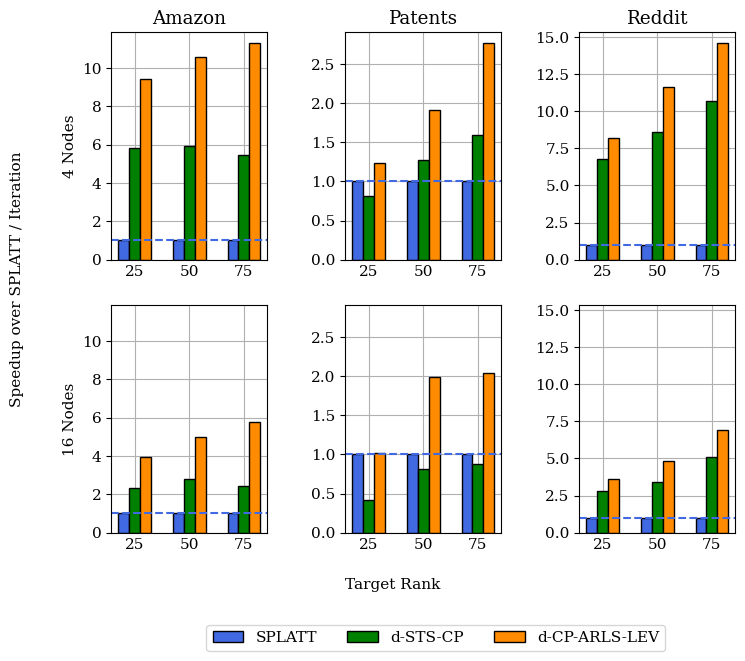

In [79]:
# Generate comparisons to the baseline
tensors = {"amazon":
        {"splatt_filename_4": "../data/baseline_runtime_comparison/amazon_baseline_4.txt",
         "splatt_filename_16": "../data/baseline_runtime_comparison/amazon_baseline_16.txt",
         "sample_count": 65536},
           "patents":
        {"splatt_filename_4": "../data/baseline_runtime_comparison/patents_baseline_4.txt",
         "splatt_filename_16": "../data/baseline_runtime_comparison/patents_baseline_16.txt",
         "sample_count": 65536},
        "reddit":
        {"splatt_filename_4": "../data/baseline_runtime_comparison/reddit_baseline_4.txt",
         "splatt_filename_16": "../data/baseline_runtime_comparison/reddit_baseline_16.txt",
         "sample_count": 65536}
       }

output = {}

ranks = [25, 50, 75]

for node_count in [4, 16]:
    splatt_key = f"splatt_filename_{node_count}"
    for tensor in tensors.keys():
        splatt_traces = parse_splatt_trace(tensors[tensor][splatt_key])

        for rank in ranks:
            trace = [trace for trace in splatt_traces if trace["rank"] == rank][0]
            avg_time_per_iteration = trace['times'][-1] / trace['iterations'][-1]
            output[(tensor, rank, 'splatt', node_count)] = avg_time_per_iteration

            for alg in ['cp_arls_lev', 'sts_cp']:
                trace =  generate_trace_ours('../data/baseline_runtime_comparison',
                                            {'input': tensor,
                                             'algorithm': alg,
                                             'sample_count': tensors[tensor]["sample_count"],
                                             'target_rank': rank,
                                             'node_count': f"{node_count}"
                                            })[0]
                avg_time_per_iteration = trace['times'][-1] / trace['iterations'][-1]
                output[(tensor, rank, alg, node_count)] = avg_time_per_iteration

            
num_tensors = 3
fig = plt.figure(tight_layout=True)
sf = 1.3
fig.set_size_inches(6 * sf, 5 * sf)
spec = fig.add_gridspec(2, num_tensors, left=0.0, right=0.8, wspace=0.5)
axs = [[fig.add_subplot(spec[i, j]) for j in range(num_tensors)] for i in range(2)]

for i in range(2):
    for j in range(num_tensors):
        axs[i][j].sharey(axs[0][j])
        axs[i][j].grid(True)
        #axs[i][j].label_outer()
            
print_names = {'splatt': 'SPLATT', 'sts_cp': 'd-STS-CP', 'cp_arls_lev': 'd-CP-ARLS-LEV'}
labelled = False
for axrow, node_count in enumerate([4, 16]):
    for idx, tensor in enumerate(tensors.keys()):
        axs[axrow][idx].axhline(1.0, linestyle='--', c=colors['splatt'])
        axs[axrow][idx].set_xticks([25, 50, 75])
        axs[axrow][idx].set_axisbelow(True)
        
        if axrow == 0:
            axs[axrow][idx].set_title(tensor.capitalize())
        
        for idx_alg, alg in enumerate(['splatt', 'sts_cp', 'cp_arls_lev']):
            width=5
            heights = np.array([output[tensor, rank, 'splatt', node_count] for rank in ranks]) / np.array([output[tensor, rank, alg, node_count] for rank in ranks])
            print(heights)

            if not labelled:
                label = print_names[alg]
            else:
                label = None

            axs[axrow][idx].bar(np.array(ranks) + width * (idx_alg - 1), heights, width=5, label=label, edgecolor='black', color=colors[alg])
            axs[axrow][idx].tick_params(axis='x', which='major',length=0)

        if not labelled:
            labelled = True
            
    axs[axrow][0].set_ylabel(f"{node_count} Nodes")
        
fig.align_labels()
fig.text(-0.13, 0.5, 'Speedup over SPLATT / Iteration', va='center', rotation='vertical')
fig.text(0.3, 0.03, 'Target Rank', va='center')
fig.legend(bbox_to_anchor=(0.72,-0.02),ncol=3)
fig.savefig('figures/speedup_over_splatt.pdf',  bbox_inches='tight')

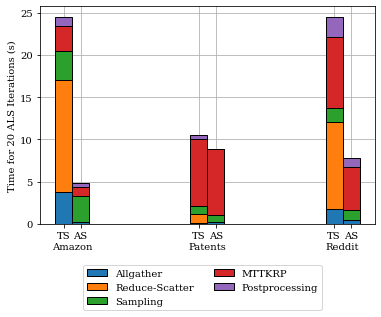

In [17]:
fig, ax = plt.subplots()
ax.grid(True)

tensors = ['amazon', 'patents', 'reddit']
dists = ['tensor_stationary', 'accumulator_stationary']

all_x = []
labels = []
mids = []
for idx1, tensor in enumerate(tensors):
    exps = []
    for idx2, dist in enumerate(dists):
        exps.append(get_strong_scaling_measurements('../data/communication_comparison', 
                                                        {
                                                        'input': tensor,
                                                        'algorithm': 'sts_cp',
                                                        'sample_count': 65536,
                                                        'target_rank': 25,
                                                        'data_distribution': dist
                                                        }))
    mid = idx1 * 4
    mids.append(mid)
    x = [mid-0.25,mid+0.25]
    all_x += x
    labels += ['TS', 'AS']
    bars = [stats_to_bar(exp) for exp in exps]
    make_stacked_barchart(ax, x, 0.5, bars, list(bars[0].keys()), vertical=True, label=(idx1==0))
    
for idx, mid in enumerate(mids):
    ax.text(mid, -3.0, tensors[idx].capitalize(), ha='center')
    
ax.set_axisbelow(True)
ax.set_xticks(all_x)
ax.set_xticklabels(labels)

ax.set_ylabel('Time for 20 ALS Iterations (s)')
fig.legend(bbox_to_anchor=(0.79,0.00),ncol=2)
fig.savefig("figures/communication_schedule_comparison.pdf", bbox_inches='tight')
fig.show()

amazon, 202154266.6637424
amazon, 150012309.78389466
amazon, 137462288.87201664
amazon, 93654528.07397337
amazon, 77498719.12284581
amazon, 64103372.62055492
amazon, 57698868.166029416
amazon, 51498919.96401626
amazon, 42504021.51985799
patents, 1098410823.633073
patents, 1343609003.2298448
patents, 1476158714.6253154
patents, 1456393493.3777351
patents, 1507952363.0465634
patents, 1440995310.3002126
patents, 1380356140.7061014
patents, 1249495563.8649027
patents, 1154308384.7660515
reddit, 486334409.6870246
reddit, 715270214.9941655
reddit, 690948773.9611455
reddit, 633882953.578729
reddit, 575585731.7832631
reddit, 512272666.7933793
reddit, 478244259.7123315
reddit, 417036864.8399456
reddit, 359592067.9213713


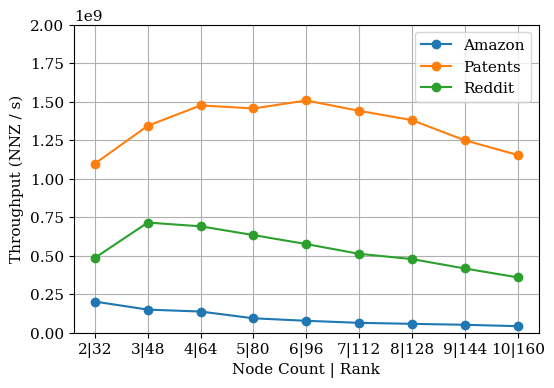

In [14]:
def get_raw_trace(directory, fields):
    exps = []
    for filepath in os.listdir(directory):
        if filepath.endswith('.out'):
            with open(os.path.join(directory, filepath), 'r') as f:
                exps.append(json.load(f))
            
    filtered_exps = []
    for exp in exps:
        match = True
        for key in fields:
            if fields[key] != exp[key]:
                match = False
        
        if match:
            filtered_exps.append(exp)
            
    return filtered_exps

step = 16
fig, ax = plt.subplots(figsize=(6,4))

tensors = ['amazon', 'patents', 'reddit']
tensor_ranks = {'amazon': [16* i for i in range(2,11)], 'patents': [16* i for i in range(2,11)], 'reddit': [16* i for i in range(2,11)]}

for tensor in tensors:
    avg_throughputs = []
    for rank in tensor_ranks[tensor]:
        exps = get_raw_trace('../data/weak_scaling',
                             {'input': tensor,
                              'algorithm': 'sts_cp',
                              'sample_count': 65536,
                              'target_rank': rank})
        throughput = np.mean([exp["stats"]["sum_nonzeros_iterated"] / exp["stats"]["als_times"][-1]  for exp in exps])
        print(f'{tensor}, {throughput}')
        avg_throughputs.append(throughput)
        
    ax.plot(np.array(tensor_ranks[tensor]) / step, avg_throughputs, '-o', label=tensor.capitalize())
    
ax.set_ylim(0,2e9)
ax.set_xlabel("Node Count | Rank")
ax.set_ylabel("Throughput (NNZ / s)")
ax.set_xticks([i for i in range(2, 11)])
ax.set_xticklabels([f'{i}|{step * i}' for i in range(2, 11)])
    
ax.grid(True)
ax.legend()
fig.savefig("figures/weak_scaling.pdf", bbox_inches='tight')

/tmp/ipykernel_2327124/3090454227.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('figures/load_imbalance.pdf', bbox_inches='tight')
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


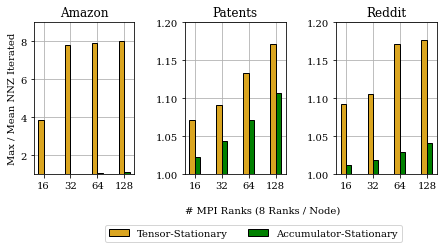

In [9]:
num_tensors = 3
fig = plt.figure(tight_layout=True)
sf = 1.4
fig.set_size_inches(5 * sf, 2 * sf)
spec = fig.add_gridspec(1, num_tensors, left=0.0, right=0.8, wspace=0.5)
axs = [fig.add_subplot(spec[i]) for i in range(num_tensors)]

tensors = ['amazon', 'patents', 'reddit']
node_counts = [2, 4, 8, 16]
distributions = ['tensor_stationary', 'accumulator_stationary']

# There was a bug with some of these experiments that the node_count field
# was not set; instead, the metadata is tagged with nnodes_{# of nodes used}

dist_colors = {'tensor_stationary': 'goldenrod',
          'accumulator_stationary': 'green'}
dist_labels = {'tensor_stationary': "Tensor-Stationary",
               'accumulator_stationary': "Accumulator-Stationary"}

labeled = False
width=0.25
for tensor_idx, tensor in enumerate(tensors):
    for dist_idx, dist in enumerate(distributions):
        imbalances = []
        for ncount_idx, node_count in enumerate(node_counts):
            exps =  get_raw_trace('../data/load_balance',
                                  {'input': tensor,
                                   'metadata': f"nnodes_{node_count}",
                                   'data_distribution': dist})
            imbalances_dist = [exp['stats']['avg_nonzeros_iterated']['max'] / exp['stats']['avg_nonzeros_iterated']['mean'] for exp in exps]
            mean_imbalance = np.mean(imbalances_dist)
            imbalances.append(mean_imbalance)
            
        xticks = np.arange(len(node_counts)) * 5 * width
        x = xticks + (width / 2 * (dist_idx - 1/2) * 2)
        
        label = None
        if not labeled:
            label = dist_labels[dist]
        
        axs[tensor_idx].bar(x=x, height=imbalances, edgecolor='black', width=width, color=dist_colors[dist], label=label)
        axs[tensor_idx].grid(True)
        axs[tensor_idx].set_axisbelow(True)
        axs[tensor_idx].set_title(tensor.capitalize())
        axs[tensor_idx].set_xticks(xticks)
        axs[tensor_idx].set_xticklabels(np.array(node_counts) * 8)
    if not labeled:
        labeled = True

axs[0].set_ylim(1, 9)
axs[1].set_ylim(1, 1.2)
axs[2].set_ylim(1, 1.2)

            
axs[0].set_ylabel("Max / Mean NNZ Iterated")
fig.text(0.3, -0.05, '# MPI Ranks (8 Ranks / Node)', va='center')
fig.legend(bbox_to_anchor=(0.74,-0.1),ncol=2)
fig.savefig('figures/load_imbalance.pdf', bbox_inches='tight')
        

/tmp/ipykernel_2139598/3460937274.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("figures/sample_scaling.pdf", bbox_inches='tight')
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


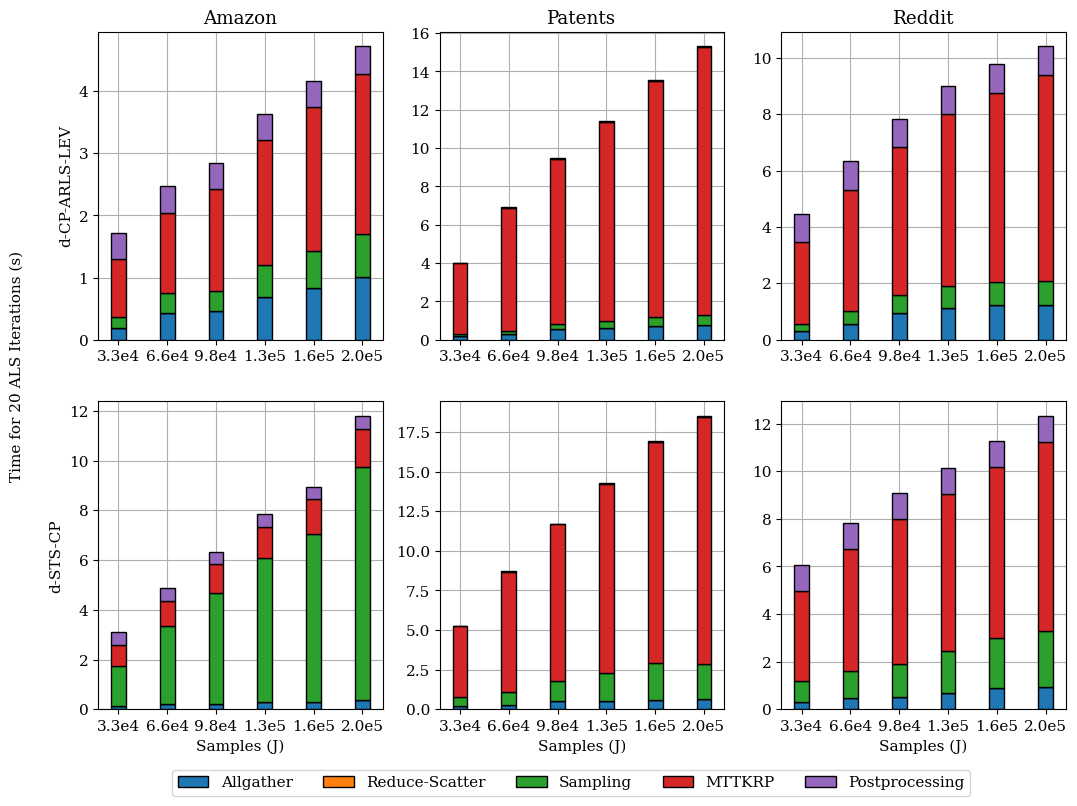

In [58]:
# Strong scaling experiments

def get_sample_scaling_measurements(directory, fields):
    exps = []
    for filepath in os.listdir(directory):
        if filepath.endswith('.out'):
            with open(os.path.join(directory, filepath), 'r') as f:
                exps.append(json.load(f))
            
    filtered_exps = []
    for exp in exps:
        match = True
        for key in fields:
            if fields[key] != exp[key]:
                match = False
        
        if match:
            filtered_exps.append(exp)
            
    results = {}
    
    stat_fields = ['leverage_sampling_time', 'row_gather_time', 'design_matrix_prep_time', 'spmm_time', 
              'dense_reduce_time', 'postprocessing_time', 'sampler_update_time']
    
    for field in stat_fields:
        if len(filtered_exps) > 0:
            results[field] = np.mean([exp['stats'][field]['mean'] for exp in filtered_exps])
        else:
            results[field] = 0.0
        
    if len(filtered_exps) > 0:
        results['als_time']=np.mean([exp['stats']['als_total_time'] for exp in filtered_exps])
    else:
        results[field] = 0.0
            
    return results

def stats_to_bar(stats):
    bar = { 'Allgather': stats['row_gather_time'],
            'Reduce-Scatter': stats['dense_reduce_time'],
            'Sampling': stats['leverage_sampling_time'],
            'MTTKRP': stats['design_matrix_prep_time'] + stats['spmm_time'],
            'Postprocessing': stats['sampler_update_time'] + stats['postprocessing_time']
          }
    return bar

num_tensors=3

fig = plt.figure(tight_layout=True)
fig.set_size_inches(8 * (1.1), 8 * (1.1))
spec = fig.add_gridspec(2, num_tensors, left=0.0, right=1.1)
axs = [[fig.add_subplot(spec[i, j]) for j in range(num_tensors)] for i in range(2)]

#for i in range(1, num_tensors):
#    axs[i].sharey(axs[0])
#    axs[i].label_outer()

for j in range(2):
    for i in range(num_tensors):
        axs[j][i].grid(True)
        
        if j == 1:
            axs[j][i].set_xlabel("Samples (J)")

            
axs[0][0].set_ylabel("d-CP-ARLS-LEV")
axs[1][0].set_ylabel("d-STS-CP")


tensors = ['amazon', 'patents', 'reddit']
algs = ['cp_arls_lev', 'sts_cp']
sample_counts = [32768 * (i+1) for i in range(6)]

for idx1, tensor in enumerate(tensors):
    for idx2, alg in enumerate(algs):
        exps = []
        for sample_count in sample_counts:
            exps.append(get_sample_scaling_measurements('../data/sample_count', 
                                                        {
                                                        'input': tensor,
                                                        'algorithm': alg,
                                                        'sample_count': sample_count,
                                                        'target_rank': 25
                                                        }))
            
        x = sample_counts
        labels = [f"{num:.1e}".replace('e+0', 'e') for num in sample_counts]
        bars = [stats_to_bar(exp) for exp in exps]
        make_stacked_barchart(axs[idx2][idx1], x, 10000, bars, list(bars[0].keys()), labels, vertical=True, label=(idx1+idx2==0))
        axs[idx2][idx1].set_axisbelow(True)
    axs[0][idx1].set_title(tensor.capitalize())

fig.text(-0.1, 0.5, 'Time for 20 ALS Iterations (s)', va='center', rotation='vertical')
fig.legend(bbox_to_anchor=(1.0,0.05),ncol=5)
fig.savefig("figures/sample_scaling.pdf", bbox_inches='tight')
fig.show()

/tmp/ipykernel_2235480/3098303701.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("figures/accuracy_vs_sample_count.pdf", bbox_inches='tight')
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


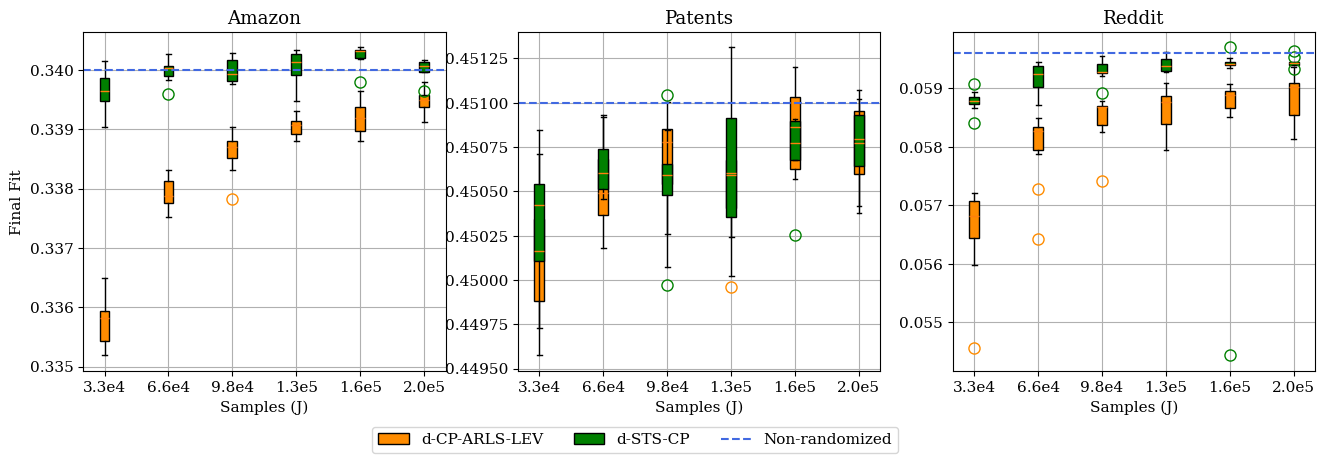

In [4]:
# Strong scaling experiments

def get_sample_scaling_mean_fit(directory, fields):
    exps = []
    for filepath in os.listdir(directory):
        if filepath.endswith('.out'):
            with open(os.path.join(directory, filepath), 'r') as f:
                exps.append(json.load(f))
            
    filtered_exps = []
    for exp in exps:
        match = True
        for key in fields:
            if fields[key] != exp[key]:
                match = False
        
        if match:
            filtered_exps.append(exp)
            
    results = {}
    fits = [exp['final_fit'] for exp in filtered_exps]
    return fits

num_tensors=3

fig = plt.figure(tight_layout=True)
fig.set_size_inches(8 * (1.1), 4 * (1.1))
spec = fig.add_gridspec(1, num_tensors, left=0.0, right=1.4)
axs = [fig.add_subplot(spec[j]) for j in range(num_tensors)]

#for i in range(1, num_tensors):
#    axs[i].sharey(axs[0])
#    axs[i].label_outer()


for i in range(num_tensors):
    axs[i].grid(True)
    axs[i].set_xlabel("Samples (J)")

            
axs[0].set_ylabel("Final Fit")


tensors = ['amazon', 'patents', 'reddit']
algs = ['cp_arls_lev', 'sts_cp']
sample_counts = [32768 * (i+1) for i in range(6)]

exact_fits = {
    'amazon': 0.340,
    'patents': 0.451,
    'reddit': 0.0596
}

legend_items = []

flierprops = {
    'cp_arls_lev': dict(marker='o', markeredgecolor=colors['cp_arls_lev'], markersize=8, linestyle="None"),
    'sts_cp': dict(marker='o', markeredgecolor=colors['sts_cp'], markersize=8, linestyle="None")
}

for idx1, tensor in enumerate(tensors):
    for idx2, alg in enumerate(algs):
        all_fits = []
        for sample_count in sample_counts:
            all_fits.append(get_sample_scaling_mean_fit('../data/sample_count_accuracy', 
                                                        {
                                                        'input': tensor,
                                                        'algorithm': alg,
                                                        'sample_count': sample_count,
                                                        'target_rank': 25
                                                        }))
            
        x = sample_counts
        labels = [f"{num:.1e}".replace('e+0', 'e') for num in sample_counts]
        bplot = axs[idx1].boxplot(all_fits, positions=x, widths=5000, patch_artist=True,flierprops=flierprops[alg])
        
        if idx1 == 0:
            legend_items.append(bplot["boxes"][0])
        
        for patch in bplot['boxes']:
            if alg=='cp_arls_lev':
                patch.set_facecolor(colors[alg])
            else:
                patch.set_facecolor(colors[alg])
        
        axs[idx1].set_xticks(x)
        axs[idx1].set_xticklabels(labels)
    axs[idx1].set_title(tensor.capitalize())
    hline = axs[idx1].axhline(exact_fits[tensor], linestyle='--', color=colors['splatt'])
    if idx1 == 0:
        legend_items.append(hline)

fig.legend(legend_items,['d-CP-ARLS-LEV', 'd-STS-CP', 'Non-randomized'], bbox_to_anchor=(0.935,0.00),ncol=5)
fig.savefig("figures/accuracy_vs_sample_count.pdf", bbox_inches='tight')
fig.show()